In [1]:
import numpy as np
import pandas as pd
import csv
import math
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import quad
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


In [2]:
#format plot


plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


count_figure=0
%matplotlib inline 

results/initial_precipitation_distribution_150C_strain_rate1.000E-04.txt


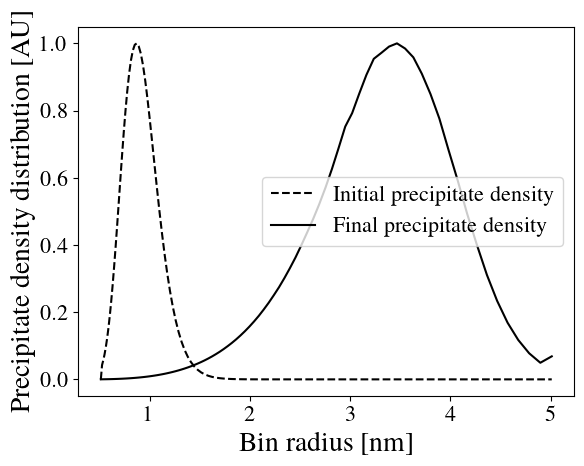

In [3]:
#chose the strain rates and temperatures for which to display the result 
strain_rate=[1.0e-4]
temperature_max=[150]

#prefix for folder where the results are stored
prefix='results/'

initial_precipitate_distribution=[]
leg=[]

suffix=[]
for j in range(len(strain_rate)):
    for i  in range(len(temperature_max)):
        #the suffix of the result files depends on the temperature and strain rate considered
        suffix.append("{temperature}C_strain_rate{str:3.3E}.txt".format(temperature=temperature_max[i], str=strain_rate[j]))
#print(suffix)

for j in range(len(strain_rate)):
    for i  in range(len(temperature_max)):
     
        
        #load and display the initial precipitate distribution
        file_name= "{pre}initial_precipitation_distribution_{suffix}".format(pre=prefix,suffix=suffix[len(temperature_max)*j+i])
        print(file_name)
        data_0=np.genfromtxt(file_name, skip_header=1)
        radius_bin=data_0[:,0]
        precipitate_density_0=data_0[:,1]
        f=plt.plot(radius_bin*1e9, precipitate_density_0/max(precipitate_density_0),'--', color='k', label='Initial precipitate density' )
        leg.append("{temperature}°C".format(temperature=temperature_max[i]))
        #load and display the final precipitate distribution
        file_name= "{pre}precipitation_distribution_{suffix}".format(pre=prefix,suffix=suffix[len(temperature_max)*j+i])
        data_0=np.genfromtxt(file_name, skip_header=1)
        final_precipitate_density=data_0
        count_figure=count_figure+1
        plt.plot(radius_bin*1e9, final_precipitate_density/max(final_precipitate_density),  color='k', label='Final precipitate density')
        leg.append("{temperature}°C".format(temperature=temperature_max[i]))
        plt.legend()
        plt.xlabel('Bin radius [nm]')
        plt.ylabel('Precipitate density distribution [AU]')
    
plt.savefig('fig_initial_final_precipitate_distribution_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')


In [4]:
#display the KWN parameters
for j in range(len(strain_rate)):

    file_name= "{pre}KWN_parameters_{end}".format(pre=prefix,end=suffix[j])
    with open(file_name, 'r') as f:
        print(f.read())
    
    print('')
    print('')

  
 KWN parameters
  
Interfacial energy:   0.265 J/m^2
Migration energy:                   0.126500E+06 J/mol
D0:                   0.149000E-04 m^2/s
  
 Initial distribution
Initial mean radius:                   0.900000E-09 m
Initial volume fraction:   0.007
Standard deviation:                   0.000000E+00
Shape parameter:   0.200
  
Starting bin :                  -0.930000E+01 m
Bin width :                   0.100000E-01 m
Number of steps :  100
  
 Vacancy model parameters 
Vacancy formation energy:   0.520 [eV]
Vacancy migration energy:   0.930 [eV]
Pre-factor diffusion vacancy:                   0.100000E-04 [m^2/s]
Mechanical vacancy production constant:   0.035 []
Vacancy sink spacing (grain size):                   0.500000E-04 [m]
Jog formation energy:   0.300 [eV]
Dislocation arrangement parameter:  10.000 []
Initial dislocation density:                   0.100000E+15 [/m^2]
Saturation dislocation density:                   0.100000E+15 [/m^2]
 
 Deformation conditions

In [5]:
time=[]
mean_radius=[]
precipitate_density=[]
vf=[]
nucleation_rate=[]
critical_radius=[]
concentration_matrix=[]
growth_rate=[]


for j in range(len(strain_rate)):
#for j in [1]   : 
    for i  in range(len(temperature_max)):
    
       # print(j)
        file_name= "{pre}kinetics_data_{suffix}".format(pre=prefix,suffix=suffix[len(temperature_max)*j+i])
        
       # print(file_name)
        data=[]
        data=np.genfromtxt(file_name, skip_header=2)
        time.append(data[:,0])
        mean_radius.append(data[:,1]) #nm 
        
        precipitate_density.append(data[:,2]) #/micron^3
        vf.append(data[:,3]) #
        nucleation_rate.append(data[:,5]) #per micron^3
        critical_radius.append(data[:,4]) #nm
        concentration_matrix.append(data[:,6]) #
        growth_rate.append(np.diff(data[:,1])/np.diff(data[:,0]))
        #print(concentration_matrix)

       # print(time)

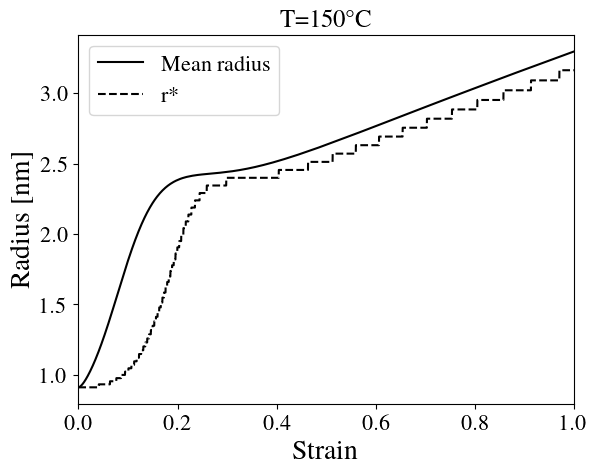

In [6]:
j=0 #without deformation
leg=[]
f_radius=[]
for j in range(len(strain_rate)):
#for j in [0]:
        
    leg.append("Strain rate : {strain_rate}".format(strain_rate=strain_rate[j]))
       
    for i  in range(len(temperature_max)):
    
        
        plt.figure(i)
        plt.xlabel('Strain')
        plt.ylabel('Mean Radius [nm]')
        
        #for j in [3]:
        f1=plt.plot(time[len(temperature_max)*j+i]*strain_rate[j], mean_radius[len(temperature_max)*j+i], 'k')
        colour=f1[0].get_color()
        f1=plt.plot(time[len(temperature_max)*j+i]*strain_rate[j], critical_radius[len(temperature_max)*j+i], '--k')
        
            #f1=plt.plot(time[len(temperature_max)*j+i], mean_radius[len(temperature_max)*j+i]*np.sqrt(3/5), '--', color=colour)
             #print(max(mean_radius[3*j+i])-min(mean_radius[3*j+i]))
        plt.legend(leg)  
        plt.title('T={temperature}°C'.format(temperature=temperature_max[i]), fontsize=18 )
       # plt.xlim([0,(temperature_max[i]-20)/heating_rate+30])
        plt.xlim([0,1.0])
        f_radius.append(interpolate.interp1d(time[len(temperature_max)*j+i],mean_radius[len(temperature_max)*j+i]))
       # plt.ylim([1.12,1.2])
    #f2=plt.plot(time[0], critical_radius[0],'--k')
#plt.figure(1)
plt.xlabel('Strain')
plt.ylabel('Radius [nm]')
plt.legend(['Mean radius', 'r*'])

#plt.legend(leg)
plt.draw
plt.show
    
plt.savefig('fig_strain_radius_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')


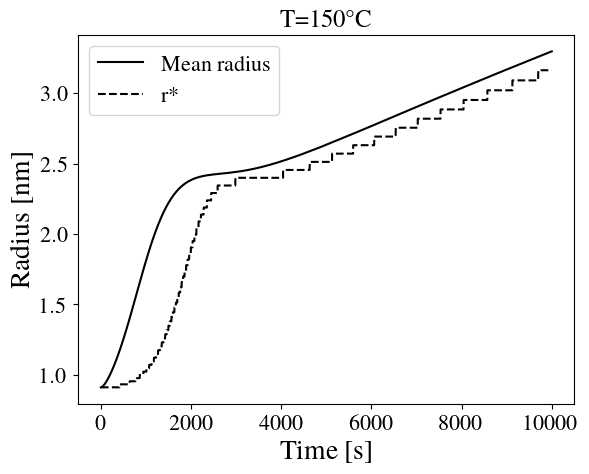

In [7]:
j=0 #without deformation
leg=[]
f_radius=[]
for j in range(len(strain_rate)):
#for j in [0]:
        
    leg.append("Strain rate : {strain_rate}".format(strain_rate=strain_rate[j]))
       
    for i  in range(len(temperature_max)):
    
        
        plt.figure(i)
        plt.xlabel('Strain')
        plt.ylabel('Mean Radius [nm]')
        
        #for j in [3]:
        f1=plt.plot(time[len(temperature_max)*j+i], mean_radius[len(temperature_max)*j+i], 'k')
        colour=f1[0].get_color()
        f1=plt.plot(time[len(temperature_max)*j+i], critical_radius[len(temperature_max)*j+i], '--k')
        
            #f1=plt.plot(time[len(temperature_max)*j+i], mean_radius[len(temperature_max)*j+i]*np.sqrt(3/5), '--', color=colour)
             #print(max(mean_radius[3*j+i])-min(mean_radius[3*j+i]))
        plt.legend(leg)  
        plt.title('T={temperature}°C'.format(temperature=temperature_max[i]), fontsize=18 )
       # plt.xlim([0,(temperature_max[i]-20)/heating_rate+30])
        
        f_radius.append(interpolate.interp1d(time[len(temperature_max)*j+i],mean_radius[len(temperature_max)*j+i]))
       # plt.ylim([1.12,1.2])
    #f2=plt.plot(time[0], critical_radius[0],'--k')
#plt.figure(1)
plt.xlabel('Time [s]')
plt.ylabel('Radius [nm]')
plt.legend(['Mean radius', 'r*'])

#plt.legend(leg)
plt.draw
plt.show
    
plt.savefig('fig_time_radius_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')


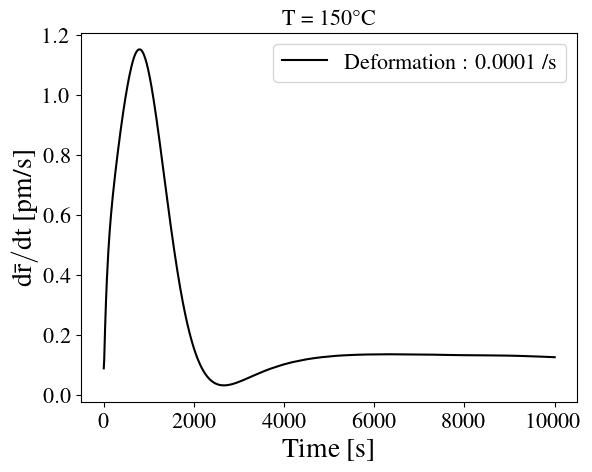

In [14]:
#%matplotlib qt 
#%matplotlib inline
j=0 #without deformation
heating_rate=5
for i  in [0]:
        for j in range(len(strain_rate)):
            t_bis= np.linspace(min(time[len(temperature_max)*j+i]),max(time[len(temperature_max)*j+i]),1000   )
           # print(t_bis)
            dt = t_bis[1]-t_bis[0]
            dydt = np.gradient(f_radius[len(temperature_max)*j+i](t_bis)*1000, dt)
            colour=f1[0].get_color()
            f1=plt.plot(t_bis,dydt, 'k', label='Deformation : {s} /s'.format(s=strain_rate[j]))
            y=dydt
            z=[0, max(y)*1.1]
            plt.legend()
            plt.show
            plt.xlabel('Time [s]')
            plt.ylabel(r'$\rm{d} \bar{r}/dt$ [pm/s]')
            plt.title('T = {t}°C'.format(t=temperature_max[i]))
           


plt.savefig('fig_time_growth_rate_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')
plt.draw()
plt.show()


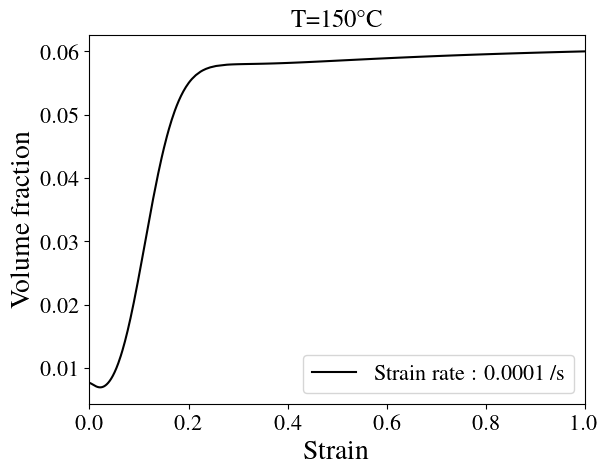

In [9]:
j=0 #without deformation
leg=[]
for j in range(len(strain_rate)):        
    leg.append("Strain rate : {strain_rate} /s".format(strain_rate=strain_rate[j]))
       
    for i  in range(len(temperature_max)):        
        plt.figure(i)
        plt.xlabel('Strain')
        plt.ylabel('Volume fraction')        
        #for j in [3]:
        f1=plt.plot(time[len(temperature_max)*j+i]*strain_rate[j], vf[len(temperature_max)*j+i], 'k')
        colour=f1[0].get_color()
        plt.legend(leg)  
        plt.title('T={temperature}°C'.format(temperature=temperature_max[i]), fontsize=18 )
        plt.xlim([0,1.0])
    
plt.savefig('fig_strain_volume_fraction_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')


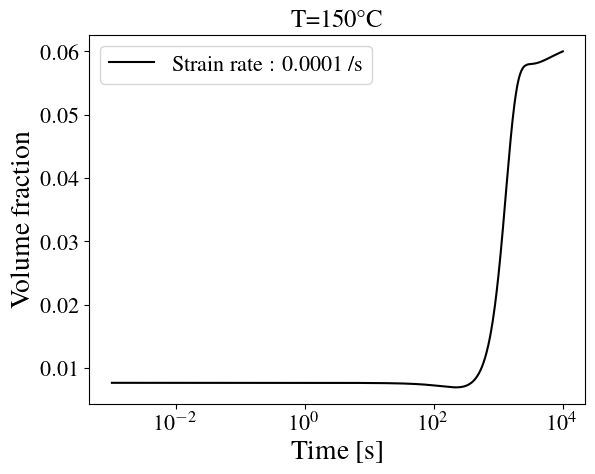

In [10]:
j=0 #without deformation
leg=[]
for j in range(len(strain_rate)):        
    leg.append("Strain rate : {strain_rate} /s".format(strain_rate=strain_rate[j]))
       
    for i  in range(len(temperature_max)):        
        plt.figure(i)
        plt.xlabel('Time [s]')
        plt.ylabel('Volume fraction')        
        #for j in [3]:
        f1=plt.semilogx(time[len(temperature_max)*j+i], vf[len(temperature_max)*j+i], 'k')
        colour=f1[0].get_color()
        plt.legend(leg)  
        plt.title('T={temperature}°C'.format(temperature=temperature_max[i]), fontsize=18 )
     
plt.savefig('fig_time_volume_fraction_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')
       

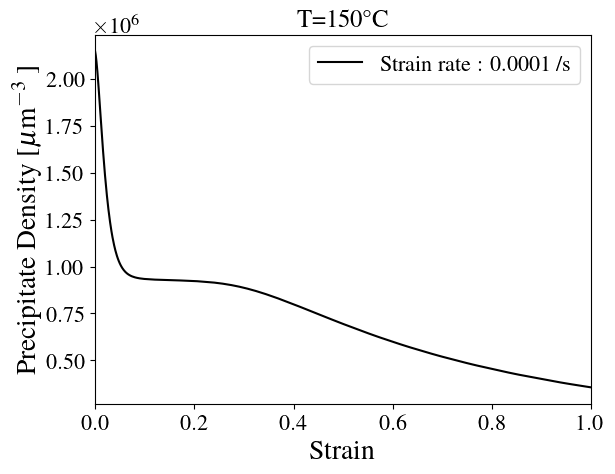

In [11]:
j=0 #without deformation
leg=[]
for j in range(len(strain_rate)):        
    leg.append("Strain rate : {strain_rate} /s".format(strain_rate=strain_rate[j]))
       
    for i  in range(len(temperature_max)):        
        plt.figure(i)
        plt.xlabel('Strain')
        plt.ylabel('Precipitate Density [$\mu$m$^{-3}$ ]')        
        #for j in [3]:
        f1=plt.plot(time[len(temperature_max)*j+i]*strain_rate[j], precipitate_density[len(temperature_max)*j+i], 'k')
        colour=f1[0].get_color()
        plt.legend(leg)  
        plt.title('T={temperature}°C'.format(temperature=temperature_max[i]), fontsize=18 )
        plt.xlim([0,1.0])
    
plt.savefig('fig_strain_number_density_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')


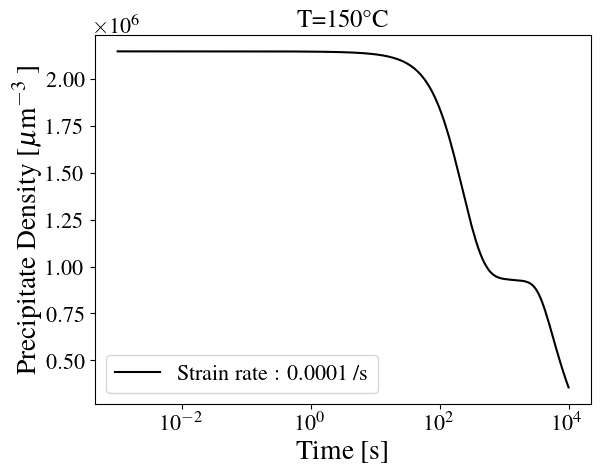

In [12]:
j=0 #without deformation
leg=[]
for j in range(len(strain_rate)):        
    leg.append("Strain rate : {strain_rate} /s".format(strain_rate=strain_rate[j]))
       
    for i  in range(len(temperature_max)):        
        plt.figure(i)
        plt.xlabel('Time [s]')
        plt.ylabel('Precipitate Density [$\mu$m$^{-3}$ ]')        
        #for j in [3]:
        f1=plt.semilogx(time[len(temperature_max)*j+i], precipitate_density[len(temperature_max)*j+i], 'k')
        colour=f1[0].get_color()
        plt.legend(leg)  
        plt.title('T={temperature}°C'.format(temperature=temperature_max[i]), fontsize=18 )
    
plt.savefig('fig_time_number_density_{s}_{t}.pdf'.format(s=strain_rate[j], t=temperature_max[i]),bbox_inches='tight')
        